In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import scipy
from tqdm.notebook import trange, tqdm

## Gen graph

In [2]:
def create_weighted_directed_graph_from_adj_matrix(adjacency_matrix):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes to the graph
    num_nodes = adjacency_matrix.shape[0]
    for i in range(num_nodes):
        G.add_node(i)

    # Add edges from adjacency matrix
    for i in range(num_nodes):
        for j in range(num_nodes):
            weight = adjacency_matrix[i, j]
            if weight > 0:  # Add an edge only if weight is greater than 0
                G.add_edge(i, j, weight=weight)

    return G

# Test the function
num_nodes = 10

# Create a num_nodes by num_nodes matrix filled with zeros
adjacency_matrix = np.zeros((num_nodes, num_nodes))

# Fill in the adjacency matrix with random edge weights, No self-connections, only 10% of the edges are connected
for i in range(num_nodes):
    for j in range(num_nodes):
        if i != j:  # No self-connections
            if random.randint(1, 10) >= 8:
                weight = random.randint(1, 10)
                adjacency_matrix[i, j] = weight

print("Adjacency Matrix:")
print(adjacency_matrix)



Adjacency Matrix:
[[ 0.  0.  0.  0.  6.  0.  0.  0.  3.  0.]
 [ 0.  0.  4.  0. 10.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  3.  9.  0.  0.  0.]
 [ 9.  0.  0.  0.  0.  0.  0.  0.  9.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  6.  9.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  8.  0.  0.  1.  0.]
 [ 0.  0.  7.  0.  0.  0.  0.  0.  0.  6.]
 [ 0.  0.  0.  0.  3.  0.  0.  0.  0.  0.]]


In [29]:
#np.save('adjacency_matrix_10.npy', adjacency_matrix)

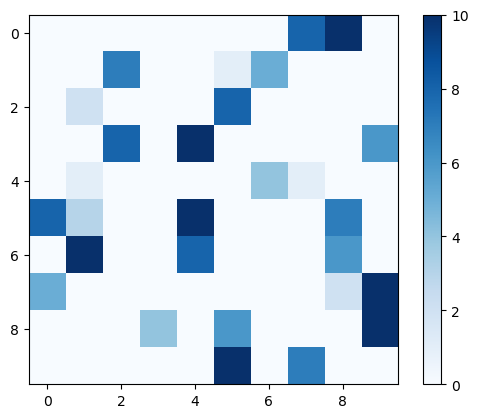

In [3]:
adjacency_matrix = np.load('adjacency_matrix_10.npy')
G = create_weighted_directed_graph_from_adj_matrix(adjacency_matrix)
plt.imshow(adjacency_matrix,cmap='Blues')
plt.colorbar()

In [4]:
# print the neighbors of node 6
print("Neighbors of node 6:")
print(list(G.neighbors(6)))

Neighbors of node 6:
[1, 4, 8]


## floyd_warshall

In [5]:
def cal_reward(path):
    reward = 0
    for i in range(len(path)-1):
        reward += adjacency_matrix[path[i],path[i+1]]
    return reward

In [6]:
import networkx as nx
import numpy as np

def floyd_warshall(G):
    # Get the number of nodes
    n = len(G.nodes)

    # Initialize the distance matrix
    dist = np.full((n, n), np.inf)

    # Initialize the predecessor matrix
    pred = np.full((n, n), None)

    # Set the diagonal of the distance matrix to 0
    np.fill_diagonal(dist, 0)

    # Populate the distance and predecessor matrices
    for u, v, d in G.edges(data=True):
        dist[u, v] = d['weight']
        pred[u, v] = u

    # Floyd-Warshall
    for k in range(n):
        for i in range(n):
            for j in range(n):
                if dist[i, k] + dist[k, j] < dist[i, j]:
                    dist[i, j] = dist[i, k] + dist[k, j]
                    pred[i, j] = pred[k, j]

    return pred, dist

def reconstruct_path(u, v, pred):
    path = []
    while v is not None:
        path.append(v)
        v = pred[u, v]
    path.reverse()
    return path

# Assume G is predefined
# G = nx.DiGraph()

# Run the Floyd-Warshall algorithm
predecessor, distance = floyd_warshall(G)


In [7]:
# Find the shortest path from 6 to 4

source, target = 6, 4

path = reconstruct_path(source, target, predecessor)
print(f'The shortest path from node {source} to node {target} is: {path}')
print(cal_reward(path))


The shortest path from node 6 to node 4 is: [6, 4]
8.0


## Q learning

In [110]:
class QLearningAgent:
    def __init__(self, graph, num_nodes, alpha=0.5, gamma=0.75, epsilon=0.2):
        self.graph = graph
        self.num_nodes = num_nodes
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_values = np.zeros((num_nodes, num_nodes))  # Q-values initialization

    def choose_action(self, state):
        neighbors = list(self.graph.neighbors(state))
        q_values = [self.q_values[state, action] for action in neighbors]
        if np.random.uniform(0, 1) < self.epsilon:
            # Choose a random action from the neighbors
            action = np.random.choice(neighbors)
        else:
            # Choose the action with highest Q-value from the neighbors
            action = neighbors[np.argmax(q_values)]
        return action

    def update(self, state, action, reward, next_state):
        # Q-learning update
        neighbors = list(self.graph.neighbors(next_state))
        next_q_values = [self.q_values[next_state, next_action] for next_action in neighbors]
        max_next_q_value = max(next_q_values) if neighbors else 0
        # apply epsilon-greedy
        if np.random.uniform(0, 1) < self.epsilon:
            # Choose a random action from the neighbors
            next_action = np.random.choice(neighbors)
            max_next_q_value = self.q_values[next_state, next_action]
        delta = reward + self.gamma * max_next_q_value - self.q_values[state, action]
        self.q_values[state, action] += self.alpha * delta
            
    def learn(self, num_episodes, max_steps_per_episode):
        for _ in trange(num_episodes):
            state = np.random.randint(0, self.num_nodes)
            for step in range(max_steps_per_episode):
                action = self.choose_action(state)
                reward = -self.graph.edges[state, action]['weight']
                next_state = action
                self.update(state, action, reward, next_state)
                if state == next_state:
                    break
                state = next_state


    def get_optimal_path(self, start_node, end_node):
        path = [start_node]
        visited = set([start_node])
        state = start_node
        while state != end_node:
            neighbors = list(self.graph.neighbors(state))
            # Filter out already visited nodes
            neighbors = [node for node in neighbors if node not in visited]
            if len(neighbors) == 0:
                # return to previous node and select another action
                visited.add(state)
                path.pop()
                state = path[-1]
                neighbors = list(self.graph.neighbors(state))
                neighbors = [node for node in neighbors if node not in visited]
                continue
            q_values = [self.q_values[state, action] for action in neighbors]
            action = neighbors[np.argmax(q_values)]
            visited.add(action)
            state = action
            path.append(state)
        return path

In [111]:
# Initialize the RLAgent
agent = QLearningAgent(G, num_nodes)

# Learn from the environment
agent.learn(num_episodes=50000, max_steps_per_episode=10)

print(compare_algorithms(G, len(G.nodes)))

# path = agent.get_optimal_path(start_node=6, end_node=4)
# print("Optimal path from node 6 to node 4: ", path)

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

(603.0, -965.0, -1568.0, 0.6154336734693877)


In [96]:
def compare_algorithms(graph, num_nodes):
    # Floyd-Warshall
    pred, _ = floyd_warshall(graph)
    floyd_warshall_rewards = 0
    for i in trange(num_nodes):
        for j in range(num_nodes):
            if i != j:
                path = reconstruct_path(i, j, pred)
                floyd_warshall_rewards += sum(-graph.edges[path[k], path[k+1]]['weight'] for k in range(len(path)-1))
    
    # Q-Learning
    q_learning_rewards = 0
    for i in trange(num_nodes):
        for j in range(num_nodes):
            if i != j:
                path = agent.get_optimal_path(i, j)
                q_learning_rewards += sum(-graph.edges[path[k], path[k+1]]['weight'] for k in range(len(path)-1))

    return floyd_warshall_rewards - q_learning_rewards, floyd_warshall_rewards, q_learning_rewards, floyd_warshall_rewards / q_learning_rewards

In [25]:
path = agent.get_optimal_path(start_node=6, end_node=4)
print("Optimal path from node 6 to node 4: ", path)
# calculate the total reward
total_reward = 0
for i in range(len(path) - 1):
    total_reward += -G.edges[path[i], path[i + 1]]['weight']
print("Total reward: ", total_reward)

Optimal path from node 6 to node 4:  [6, 8, 5, 4]
Total reward:  -22.0
